In [62]:
import pennylane as qml
from pennylane import AdamOptimizer
import pennylane.numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [63]:
dev = qml.device("default.qubit")

In [64]:
n_qubits = 1
n_layers = 1
shape_weights = (n_layers, n_qubits, 3)
weights_init =  np.random.randn(n_layers,n_qubits,3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [65]:
def layer(weights_da_camada):
    for i in range(n_qubits):
        qml.RY(weights_da_camada[i, 1], wires=i)

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    for i in range(n_qubits):
        qml.RY(weights_da_camada[i, 1], wires=i)


@qml.qnode(dev)
def circuito(weights, x):
    qml.AmplitudeEmbedding(
        features=x,
        wires=range(n_qubits),
    )

    for layer_w in weights:
        layer(layer_w)

    return qml.expval(qml.PauliZ(0))


In [66]:
def cost(weights, bias, X, Y):
    raw_preds = [circuito(weights, x) + bias for x in X]
    predictions = qml.math.stack(raw_preds)

    probs = 1 / (1 + qml.math.exp(-predictions))

    loss = -qml.math.mean(
        Y * qml.math.log(probs + 1e-7)
        + (1 - Y) * qml.math.log(1 - probs + 1e-7)
    )
    return loss


In [67]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [68]:
opt = qml.AdamOptimizer(0.01)

In [69]:
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples=500,
    centers=2,
    n_features=2,
    cluster_std=1.4,
    random_state=42
)


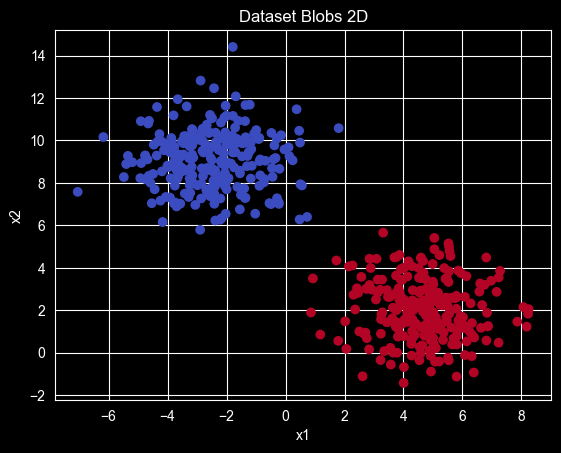

In [70]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Blobs 2D")
plt.show()


In [71]:
print(X)

[[-3.18004156e+00  8.75436356e+00]
 [-4.63046511e+00  1.09279101e+01]
 [-3.87375196e+00  1.01162046e+01]
 [-2.68828225e+00  7.67652951e+00]
 [ 3.31072039e+00  5.65850457e+00]
 [-4.65695746e+00  1.08030337e+01]
 [ 1.17957654e+00  8.57516326e-01]
 [ 3.75849472e-01  1.14717633e+01]
 [-8.57981454e-01  8.35744022e+00]
 [ 4.05161729e+00  1.57867123e+00]
 [-4.05806659e+00  7.33959685e+00]
 [ 6.97154306e+00  3.39328777e+00]
 [-8.80768370e-01  9.02861241e+00]
 [-1.37166147e+00  1.09130222e+01]
 [ 5.04556364e+00  4.87873080e+00]
 [ 6.01793019e+00  1.67358530e+00]
 [ 4.92324102e-01  9.90177276e+00]
 [ 5.52577345e+00  5.15213968e+00]
 [-1.35763475e+00  7.30510502e+00]
 [-4.91415018e-01  7.00407912e+00]
 [ 3.55657396e+00  2.30653099e-01]
 [-2.41920560e+00  7.50544344e+00]
 [-2.44539705e+00  8.10204564e+00]
 [ 5.94982859e+00  3.75334682e+00]
 [ 4.13082174e+00  1.89344581e+00]
 [-1.68759769e+00  1.20809240e+01]
 [ 3.74753686e+00  3.63779283e+00]
 [ 6.32157833e+00  1.40186416e+00]
 [-2.06242824e-01  8

In [72]:
def pad_features(X):
    X_pad = np.zeros((X.shape[0], 2))
    X_pad[:, :2] = X
    return X_pad

X_pad = pad_features(X)
X_pad = X_pad / np.linalg.norm(X_pad, axis=1, keepdims=True)
y = y.astype(float)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)

In [73]:
print(X_train)

[[-3.37408334e-01  9.41358389e-01]
 [-3.67641849e-02  9.99323969e-01]
 [-6.99892073e-02  9.97547749e-01]
 [ 9.96139866e-01  8.77802215e-02]
 [ 8.40409395e-01  5.41952073e-01]
 [-2.76834412e-01  9.60917639e-01]
 [-3.94009400e-01  9.19106410e-01]
 [-4.70358200e-01  8.82475588e-01]
 [-7.51463366e-02  9.97172517e-01]
 [ 8.94005403e-01  4.48056178e-01]
 [ 9.17564567e-01  3.97586803e-01]
 [ 9.91205377e-01  1.32332536e-01]
 [ 8.34880913e-01  5.50430615e-01]
 [-1.38347800e-01  9.90383707e-01]
 [ 7.50125921e-01  6.61295020e-01]
 [-3.72948078e-01  9.27852214e-01]
 [-3.47506809e-01  9.37677459e-01]
 [-2.21685221e-01  9.75118282e-01]
 [-2.71247892e-01  9.62509523e-01]
 [ 9.63525819e-01  2.67615388e-01]
 [-2.23386088e-01  9.74730042e-01]
 [-5.52175866e-01  8.33727661e-01]
 [ 7.15463744e-01  6.98649863e-01]
 [ 6.23472486e-01  7.81845291e-01]
 [ 9.66124561e-01  2.58076216e-01]
 [ 9.37727048e-01  3.47372973e-01]
 [-8.76722411e-02  9.96149375e-01]
 [ 6.34845161e-01  7.72639387e-01]
 [ 9.64117812e-01  2

In [74]:
weights = weights_init
bias = bias_init
epochs = 200
batch_size = 70 # Exemplo
from tqdm import tqdm
pbar = tqdm(total=epochs, desc="Epoch")
for it in range(epochs):
    # Amostragem do Batch
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]

    # Passo de Otimização
    # Note: passamos X e Y com as letras maiúsculas para bater com a def cost(..., X, Y)
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # --- OTIMIZAÇÃO DE LOGS ---
    # Só calcula a acurácia total a cada 10 passos para não travar o PC
    current_predictions = [np.sign(circuito(weights, x) + bias) for x in X_train]

    current_cost = cost(weights, bias, X_batch, Y_batch)

    acc = accuracy(y_train, current_predictions)
    pbar.update(1)
    pbar.set_postfix(loss=current_cost)

Epoch: 100%|██████████| 200/200 [05:54<00:00,  1.75s/it, loss=0.3536751240104143] 

In [79]:
def predict_proba(X, weights, bias):
    raw = [circuito(weights, x) + bias for x in X]
    raw = qml.math.stack(raw)
    return 1 / (1 + qml.math.exp(-raw))
def predict(X, weights, bias):
    probs = predict_proba(X, weights, bias)
    return (probs >= 0.5).astype(int)
y_pred = predict(X_val, weights, bias)
acc = (y_pred == y_val).mean()

print(f"Acurácia validação: {acc:.3f}")


Acurácia validação: 1.000


In [80]:
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 150),
        np.linspace(y_min, y_max, 150)
    )

    grid_2d = np.c_[xx.ravel(), yy.ravel()]
    grid_pad = np.zeros((grid_2d.shape[0], 2))
    grid_pad[:, :2] = grid_2d

    grid_pad = grid_pad / np.linalg.norm(grid_pad, axis=1, keepdims=True)
    probs_grid = predict_proba(grid_pad, weights, bias)
    Z = probs_grid.reshape(xx.shape)


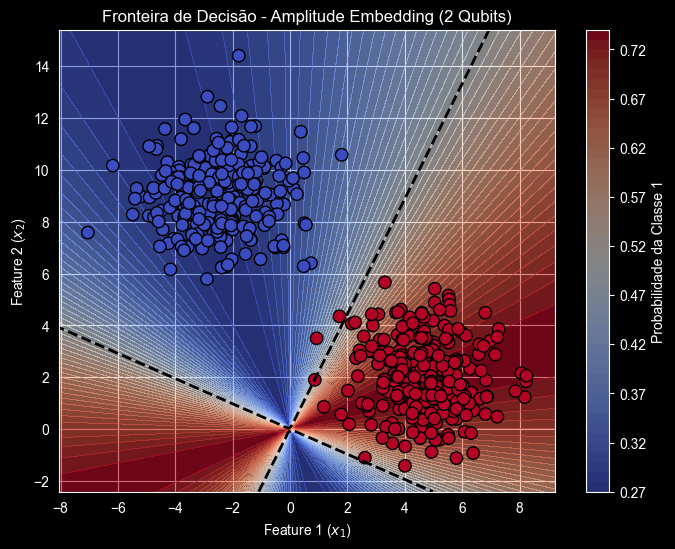

In [82]:
plt.figure(figsize=(8, 6)) # Levemente mais largo para a colorbar

contour = plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
plt.colorbar(contour, label="Probabilidade da Classe 1") # Adiciona a legenda de cor

# A linha de decisão rígida
plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2, linestyles="dashed")

# Os pontos de dados
plt.scatter(
    X[:, 0], X[:, 1],
    c=y,
    cmap="coolwarm",
    edgecolors="k",
    s=80 # Aumenta um pouco o tamanho dos pontos
)

plt.xlabel("Feature 1 ($x_1$)")
plt.ylabel("Feature 2 ($x_2$)")
plt.title("Fronteira de Decisão - Amplitude Embedding (1 Qubits)")
plt.show()